# Problem Statement
- Is there a relationship between advertising sales and budget? (Inference)
- Which media contribute to sales, and how strong is the relationship? (Inference)
- Is the relationship linear? (Inference) 
- Is there synergy among the advertising media? (Inference)
- How accurately can we predict future sales? (Prediction)

# Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
sns.set()

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm # Note the short form
import statsmodels.formula.api as smf # Note the short form
import pandas_profiling
%matplotlib inline

# Load data

In [169]:
# Open Advertising CSV to take a look at what the data looks like
# Observe that first column is redundant
advertising = pd.read_csv('Data/Advertising.csv', usecols=[1,2,3,4])
# Check that it is read correctly
advertising.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [8]:
profile = advertising.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="output.html")
# Search for file in where this Jupyter Notebook is located

# Checking for collinearity
**What is collinearity?**
- Collinearity refers to the situation in which two or more predictor variables are closely related to one another.

**Why is collinearity important?**
- The presence of collinearity can pose problems in the regression context, since it can be difficult to separate out the individual effects of collinear variables on the response.

- Since collinearity reduces the accuracy of the estimates of the regression coefficients, it causes the standard error for ˆβj to grow. Recall that the t-statistic for each predictor is calculated by dividing ˆβj by its standard error. Consequently, collinearity results in a decline in the t statistic. As a result, in the presence of collinearity, we may fail to reject H0 : βj = 0. This means that the power of the hypothesis test—the probability of correctly power detecting a non-zero coefficient—is reduced by collinearity.

**How to assess collinearity?**
- DO NOT assess collinearity using correlation matrix plot. 
    - It is possible for collinearity to exist between three or more variables even if no pair of variables has a particularly high correlation. We call this situation multicollinearity
- DO assess collinearity using Variance Inflation Factor (VIF)

\begin{equation}\label{eq:}
\textrm{VIF}_j = \frac{1}{1-R_{j|X-j}^2}
\end{equation}

- {1-R_{j|X-j}^2} is the R2 from a regression of Xj onto all of the other predictors.

- VIF = 1 --> No collinearity
- VIF > 5 --> High collinearity

**What to do with collinear predictors?**
- Drop one of the problematic variables from the regression
- Combine the standardized version of the collinear variables together into a single predictor

In [167]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF_matrix = advertising[['TV','Radio','Newspaper']]
# The function's author expects the presence of a constant in the matrix of explanatory variables.
VIF_matrix['const'] = 1 
VIF_matrix.head()

,TV,Radio,Newspaper,const
0,230.1,37.8,69.2,1
1,44.5,39.3,45.1,1
2,17.2,45.9,69.3,1
3,151.5,41.3,58.5,1
4,180.8,10.8,58.4,1


In [168]:
VIF = pd.Series([variance_inflation_factor(VIF_matrix.values, i) 
               for i in range(VIF_matrix.shape[1])], 
              index=VIF_matrix.columns)
VIF

TV           1.004611
Radio        1.144952
Newspaper    1.145187
const        6.848900
dtype: float64

## Conclusion
VIF values are all below 5, so there is no high collinearity present

# Is there a relationship between advertising sales and budget? (Inference)
- Answer this question by testing the hypothesis H0 : βTV = βradio = βnewspaper = 0 using the F-statistic.
- No relationship between response and predictor --> F-stat = 1
- Relationship between response and predictor --> F-stat > 1

## Why overall F-statistic and not individual t-statistic?
"Torture the data long enough, and it will tell you what you want to hear"

It seems likely that if any one of the p-values for the individual variables is very small, then at least one of the predictors is related to the response. However, this logic is flawed, especially
when the number of predictors p is large.

For instance, consider an example in which p = 100 and H0 : β1 = β2 = . . . = βp = 0 is true, so no variable is truly associated with the response. In this situation, about 5% of the p-values associated with each variable will be below 0.05 by chance. In other words, we expect to see approximately five small p-values even in the absence of any true association between the predictors and the response. we are almost guaranteed that we will observe at least one p-value below 0.05 by chance!

Hence, if we use the individual t-statistics and associated p-values in order to decide whether or not there is any association between the variables and the response, there is a very high chance that we will incorrectly conclude that there is a relationship. However, the F-statistic does not suffer from this problem because it adjusts for the number of predictors.

The approach of using an F-statistic to test for any association between the predictors and the response works when p is relatively small, and certainly small compared to n

## How large does F-statistic need to be?
When n is large, an F-statistic that is just a little larger than 1 might still provide evidence against H0. In contrast, a larger F-statistic is needed to reject H0 if n is small.

In [170]:
estimates = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
estimates.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.897
Model:,OLS,Adj. R-squared:,0.896
Method:,Least Squares,F-statistic:,570.3
Date:,"Wed, 27 Nov 2019",Prob (F-statistic):,1.58e-96
Time:,00:09:17,Log-Likelihood:,-386.18
No. Observations:,200,AIC:,780.4
Df Residuals:,196,BIC:,793.6
Df Model:,3,,
Covariance Type:,nonrobust,,


We observe that F-statistic is 570 >> 1, implying a strong relationship. The associated p-value in Prob(F-statistic) is extremely small, lower than the threshold alpha set at 0.05. As such we can conclude that there is indeed a relationship between sales and advertising budget

# Which media contribute to sales?

- We can examine the p-values associated with each predictor’s t-statistic
- We can also examine the confidence intervals for each predictor. There is a strong relationship if the confidence intervals are narrow and far from zero

## TV

In [171]:
estimates_tv = smf.ols('Sales ~ TV', advertising).fit()
estimates_tv.summary().tables[1] # to check p-value/confidence interval

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


## Radio

In [172]:
estimates_radio = smf.ols('Sales ~ Radio', advertising).fit()
estimates_radio.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
Radio,0.2025,0.020,9.921,0.000,0.162,0.243


## Newspaper

In [173]:
estimates_newspaper = smf.ols('Sales ~ Newspaper', advertising).fit()
estimates_newspaper.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


## Overall (use this)

In [174]:
estimates_overall = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
estimates_overall.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
Radio,0.1885,0.009,21.893,0.000,0.172,0.206
Newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


## Conclusion
**Interpretation of p-value**
- For a given amount of TV and newspaper advertising, spending an additional $1,000 on radio advertising leads to an increase in sales by approximately 189 units.

- However, while the newspaper regression coefficient estimate in the single regression model was significantly non-zero, the coefficient estimate for newspaper in the multiple regression model is close to zero, and the corresponding p-value is no longer significant, with a value around 0.86. This suggests that the Newspaper variable can be ignored.

**Explain the difference in p-value for Newspaper between simple regression and multiple regression model**
- In the simple regression case, the slope term represents the average effect of a $1,000 increase in newspaper advertising, ignoring other predictors such as TV and radio. 

- In the multiple regression setting, the coefficient for newspaper represents the average effect of increasing newspaper spending by $1,000 while holding TV and radio fixed.

**Interpretation of confidence interval**

- The confidence intervals for TV and radio are narrow and far from zero, providing evidence that these media are related to sales. But the interval for newspaper includes zero, indicating that the variable is not statistically significant given the values of TV and radio.

### Verifying conclusion that Newspaper can be ignored via R2
- R2 is a measure of how much of the variance in Y is accounted for by the model.

- Understand that R2 will always increase with the addition of new variables, because adding another variable to the least squares equations must allow us to fit the training data (though not necessarily the testing data) more accurately.

- Size of R2 increase with predictor addition/removal is important, not just general increase

- Given the observation that R2 = 0.897 for both with and without Newspaper, we can verify that Newspaper is indeed a non-significant predictor

In [175]:
estimates_with_newspaper = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
estimates_with_newspaper.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.897
Model:,OLS,Adj. R-squared:,0.896
Method:,Least Squares,F-statistic:,570.3
Date:,"Wed, 27 Nov 2019",Prob (F-statistic):,1.58e-96
Time:,00:09:22,Log-Likelihood:,-386.18
No. Observations:,200,AIC:,780.4
Df Residuals:,196,BIC:,793.6
Df Model:,3,,
Covariance Type:,nonrobust,,


In [176]:
estimates_without_newspaper = smf.ols('Sales ~ TV + Radio', advertising).fit()
estimates_without_newspaper.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.897
Model:,OLS,Adj. R-squared:,0.896
Method:,Least Squares,F-statistic:,859.6
Date:,"Wed, 27 Nov 2019",Prob (F-statistic):,4.83e-98
Time:,00:09:23,Log-Likelihood:,-386.20
No. Observations:,200,AIC:,778.4
Df Residuals:,197,BIC:,788.3
Df Model:,2,,
Covariance Type:,nonrobust,,


# Is the relationship linear?
- Answer this question by checking the residual plots of Y_hat obtained from a linear model vs Y.
- Inferring the residual plot: If there is no clear pattern in the residual plot, the relationship is linear. If there is a clear pattern in the residual plot, the relationship might be non-linear

In [177]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression() # Set-up linear model using Sklearn

## Residual Plot for TV

intercept: 14.0225
gradient: 0.04753664043301976


Text(0, 0.5, 'Residuals')

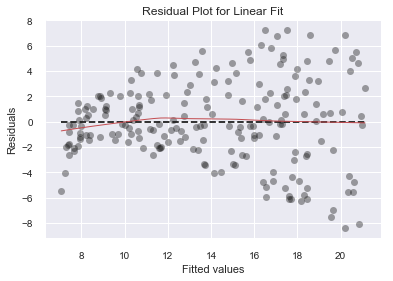

In [178]:
# Getting it to the same form as the one in the textbook
# with_std = False gets it to scale back to non-normalized variance
# Reshape(-1,1) -1 simply means that it is an unknown dimension and we want numpy to figure it out
# we just specify that we want 1 column
X = scale(advertising['TV'], with_mean=True, with_std=False).reshape(-1,1)
y = advertising['Sales']
# Note that we are working with column vectors of (n,1) for X
# Note that we are working with (n,) for y

regr.fit(X, y) 
print('intercept: ' + str(regr.intercept_)) # B0
print('gradient: ' + str(regr.coef_[0])) # B1

advertising['Y_pred(TV)'] = regr.predict(X) # Get Y_predict values

# Residual = Y_hat - Y
advertising['residual(TV)'] = advertising['Sales'] - advertising['Y_pred(TV)']
         
# Residual Plot
sns.regplot(advertising['Y_pred(TV)'],
            advertising['residual(TV)'],
            lowess=True,
            line_kws={
                'color': 'r',
                'lw': 1
            }, scatter_kws={'facecolors':'k', 'alpha':0.4})
plt.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='--')
plt.title('Residual Plot for Linear Fit')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

## Residual Plot for Radio

intercept: 9.311638095158283
gradient: 0.20249578339243968


Text(0, 0.5, 'Residuals')

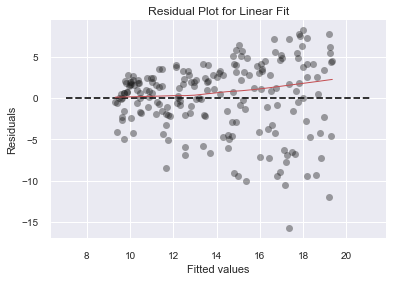

In [179]:
# Getting it to the same form as the one in the textbook
# with_std = False gets it to scale back to non-normalized variance
# Reshape(-1,1) -1 simply means that it is an unknown dimension and we want numpy to figure it out
# we just specify that we want 1 column
X = advertising['Radio'].values.reshape(-1,1)
y = advertising['Sales']
# Note that we are working with column vectors of (n,1) for X
# Note that we are working with (n,) for y

regr.fit(X, y) 
print('intercept: ' + str(regr.intercept_)) # B0
print('gradient: ' + str(regr.coef_[0])) # B1

advertising['Y_pred(Radio)'] = regr.predict(X) # Get Y_predict values

# Residual = Y_hat - Y
advertising['residual(Radio)'] = advertising['Sales'] - advertising['Y_pred(Radio)']
         
# Residual Plot
sns.regplot(advertising['Y_pred(Radio)'],
            advertising['residual(Radio)'],
            lowess=True,
            line_kws={
                'color': 'r',
                'lw': 1
            }, scatter_kws={'facecolors':'k', 'alpha':0.4})
plt.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='--')
plt.title('Residual Plot for Linear Fit')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

## 3D plot of regression of Sales on TV+Radio

In [180]:
regr = skl_lm.LinearRegression()
X = advertising[['Radio', 'TV']]
y = advertising['Sales']
regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[0.18799423 0.04575482]
2.9210999124051398


In [181]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])

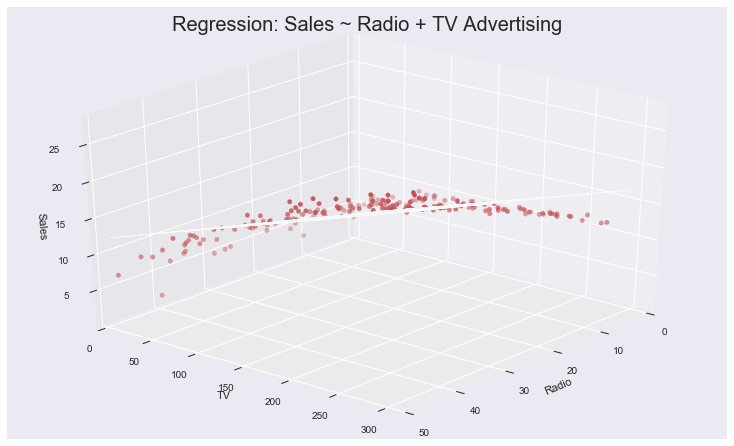

In [182]:
# Create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)

ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising['Radio'], advertising['TV'], advertising['Sales'], c='r')

ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('Sales');
ax.view_init(30, 40)

## Conclusion
Residual plots show increasing deviation for higher values of Y, suggesting that there is departure from linearity.

Regression plot shows that the positive residuals (those visible above the surface), tend to lie along the 45-degree line, where TV and Radio budgets are split evenly. The negative residuals (most not visible), tend to lie away from this line, where budgets are more lopsided. This strongly suggest that there are synergistic effects that are not accounted for in the linear model, where Radio might boost the effectiveness of TV and vice versa

There are usually 2 explanations:
- Non-inclusion of interaction effects
- Main effect is non-linear

# Is there synergy among the advertising media?

We can answer this question by checking the P-value of the coefficient of TV*Radio

Interpretation of 'coef' of TV/Radio - suggest that an increase in TV advertising of 1,000 is associated with increased sales of (β1+ β3 ×radio)×1,000 = 19+1.1×radio units. And an increase in radio advertising of $1,000 will be associated with an increase in sales of ( ˆ β2 + ˆ β3 × TV) × 1,000 = 29 + 1.1 × TV units.

In [183]:
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


## Conclusion
The p-value for the interaction term, TV×radio, is extremely low, indicating that there is strong evidence for Ha : β3 != 0. In other words, it is clear that the true relationship is not additive.

### Verifying conclusion that interaction effect is present via R2

We observe a significant improvement in R2 from 0.897 to 0.968 with the inclusion of the interaction term, hence confirming that the interaction effect should be present

In [184]:
est_with_interaction = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est_with_interaction.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.968
Model:,OLS,Adj. R-squared:,0.967
Method:,Least Squares,F-statistic:,1963.
Date:,"Wed, 27 Nov 2019",Prob (F-statistic):,6.68e-146
Time:,00:09:27,Log-Likelihood:,-270.14
No. Observations:,200,AIC:,548.3
Df Residuals:,196,BIC:,561.5
Df Model:,3,,
Covariance Type:,nonrobust,,


In [185]:
est_without_interaction = smf.ols('Sales ~ TV + Radio', advertising).fit()
est_without_interaction.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.897
Model:,OLS,Adj. R-squared:,0.896
Method:,Least Squares,F-statistic:,859.6
Date:,"Wed, 27 Nov 2019",Prob (F-statistic):,4.83e-98
Time:,00:09:27,Log-Likelihood:,-386.20
No. Observations:,200,AIC:,778.4
Df Residuals:,197,BIC:,788.3
Df Model:,2,,
Covariance Type:,nonrobust,,


# How accurately can we predict future sales?

- Check test MSE and R2, not train MSE and R2

In [186]:
# Create interaction effect in advertising
advertising['TV*Radio'] = advertising['TV']*advertising['Radio'] 

In [187]:
X = advertising[['TV','Radio','TV*Radio']]
y = advertising['Sales']

## Split train-test
- We want to minimize test MSE, not train MSE

In [188]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.5) #split 50%

In [189]:
regr.fit(X_train,y_train)
print('intercept: ' + str(regr.intercept_)) # sk_learn variable name holding B0
print('gradient: ' + str(regr.coef_)) # sk_learn variable name holding B1, B2, B3

intercept: 6.676477454336711
gradient: [0.01868259 0.03634585 0.00108331]


In [191]:
y_predict = regr.predict(X_test)

## Prediction accuracy

In [193]:
from sklearn import metrics
mse_test = metrics.mean_squared_error(y_test, y_predict)
r2_test = metrics.r2_score(y_test, y_predict)
print('MSE: ' + str(mse))
print('R2: ' + str(r2))

MSE: 1.040376460271871
R2: 0.961346280358314
